In [ ]:
!pip install scanpy scrublet magic-impute scprep matplotlib pandas numpy seaborn gseapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of scprep to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 113.8 MB/s eta 0:00:00
  Created wheel for an

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 137.8 MB/s eta 0:00:00
Loaded data shape: (9454, 3012)
Recalculating highly variable genes and PCA for the subcluster...


/tmp/ipython-input-3832908887.py:32: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata_sub, resolution=0.5, key_added='leiden_tnbc_sub')


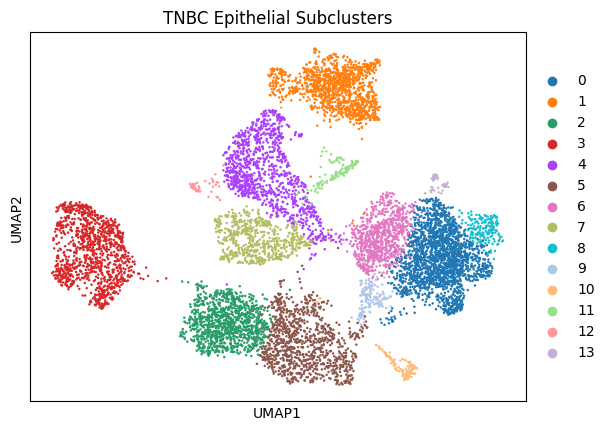

Running DEG analysis...


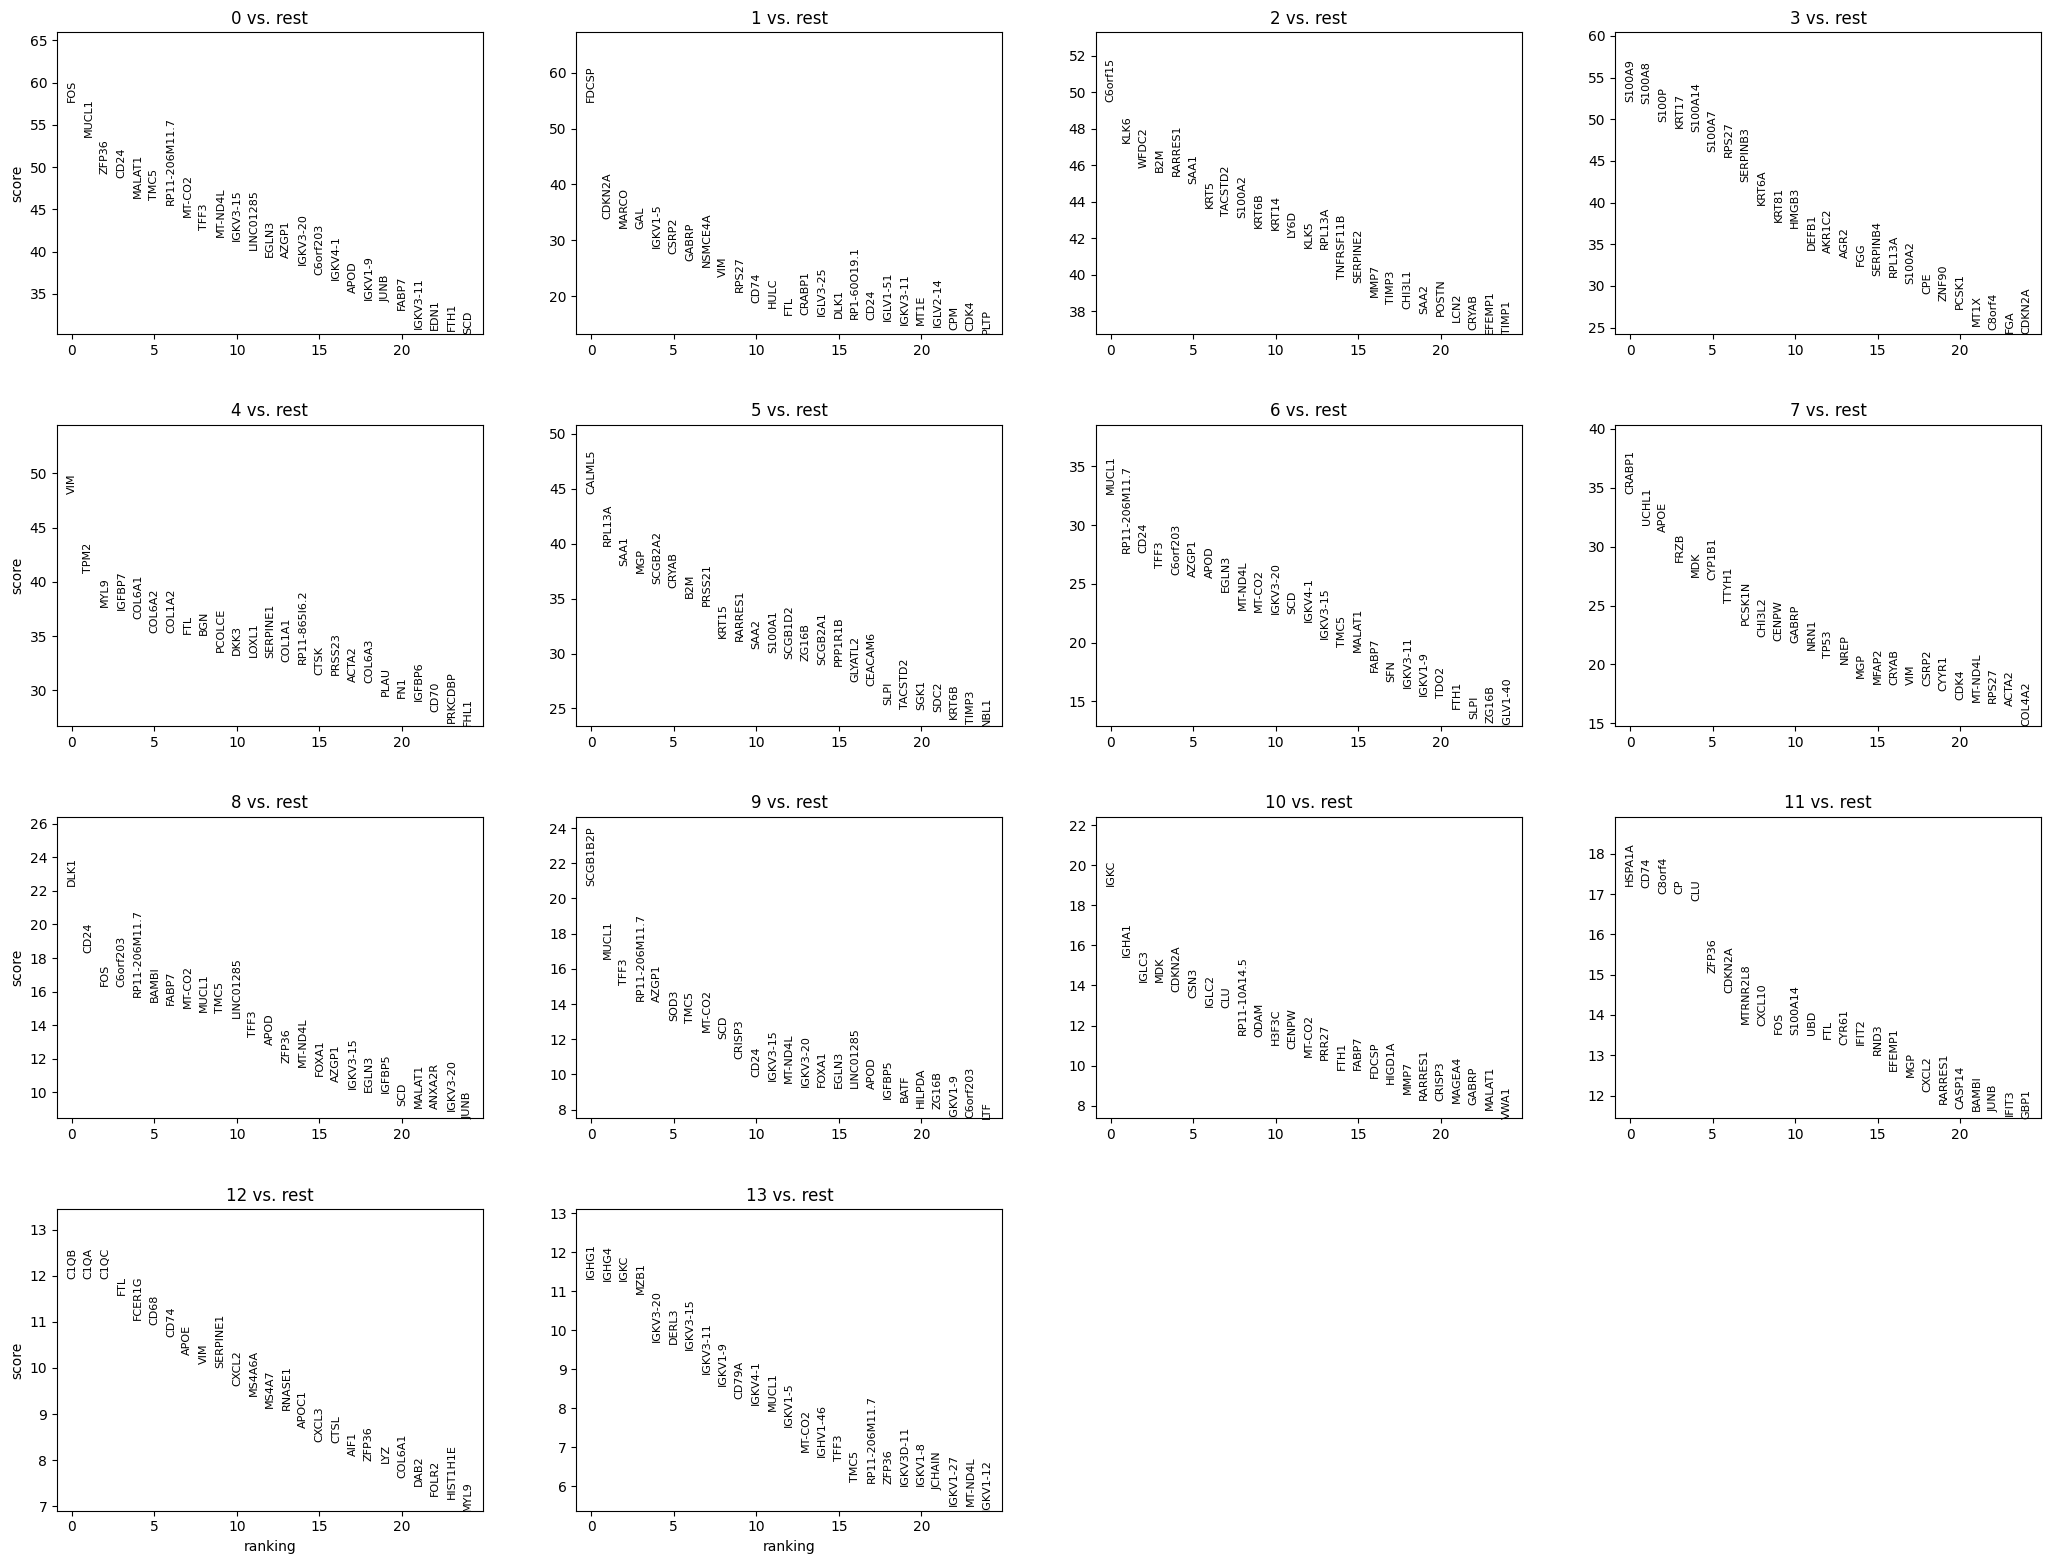

  group          names     scores  logfoldchanges  pvals  pvals_adj
0     0            FOS  57.721561        3.488466    0.0        0.0
1     0          MUCL1  53.578396        5.390509    0.0        0.0
2     0          ZFP36  49.227039        2.962587    0.0        0.0
3     0           CD24  48.675282        3.867880    0.0        0.0
4     0         MALAT1  46.368023        2.630223    0.0        0.0
5     0           TMC5  46.102100        3.575005    0.0        0.0
6     0  RP11-206M11.7  45.473606        3.605268    0.0        0.0
7     0         MT-CO2  44.146355        2.299866    0.0        0.0
8     0           TFF3  42.513725        3.202766    0.0        0.0
9     0        MT-ND4L  41.752247        3.189912    0.0        0.0


In [ ]:
!pip install leidenalg
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load the specific TNBC Epithelial file
adata_sub = sc.read_h5ad("/content/cancer_epithelial_tnbc.h5ad")

print(f"Loaded data shape: {adata_sub.shape}")

# 2. Pre-processing for Subclustering
# Even if the parent data was processed, we re-calculate HVGs and PCA
# to find variation specific to this subgroup.
print("Recalculating highly variable genes and PCA for the subcluster...")

# basic normalization check (optional if already normalized)
if adata_sub.X.max() > 20:
    sc.pp.normalize_total(adata_sub, target_sum=1e4)
    sc.pp.log1p(adata_sub)

sc.pp.highly_variable_genes(adata_sub, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.tl.pca(adata_sub, svd_solver='arpack')

# 3. Neighbors & UMAP
# We need a new neighborhood graph to define the new subclusters
sc.pp.neighbors(adata_sub, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_sub)

# 4. Subcluster (Leiden)
# This creates the new clusters specifically within the TNBC Epithelial group
# Resolution 0.4 - 0.6 is usually a good starting point for subclustering
sc.tl.leiden(adata_sub, resolution=0.5, key_added='leiden_tnbc_sub')

# Visualize
sc.pl.umap(adata_sub, color=['leiden_tnbc_sub'], title='TNBC Epithelial Subclusters')

# 5. Differential Expression Analysis (DEGs)
# Find genes that distinguish these new subclusters from each other
print("Running DEG analysis...")
sc.tl.rank_genes_groups(adata_sub, groupby='leiden_tnbc_sub', method='wilcoxon')

# Plot top 5 genes per cluster
sc.pl.rank_genes_groups(adata_sub, n_genes=25, sharey=False)

# 6. Extract DEGs to a DataFrame
# This gives you a table of the top genes for every subcluster
deg_df = sc.get.rank_genes_groups_df(adata_sub, group=None)

# Filter for significance (optional but recommended)
significant_degs = deg_df[(deg_df.pvals_adj < 0.01) & (deg_df.logfoldchanges > 1.0)]

print(significant_degs.head(10))

# Save results
# significant_degs.to_csv('TNBC_Epithelial_Subcluster_DEGs.csv')
# adata_sub.write('cancer_epithelial_tnbc_processed.h5ad')

In [ ]:
# Print the number of highly variable genes
print(f"Number of Highly Variable Genes: {adata_sub.var.highly_variable.sum()}")

Number of Highly Variable Genes: 438


In [ ]:
print(adata_sub.obs['leiden_tnbc_sub'].value_counts())

leiden_tnbc_sub
0     1963
1     1212
2     1073
3     1066
4     1059
5     1013
6      800
7      606
8      181
9      145
10     125
11     120
12      48
13      43
Name: count, dtype: int64


In [ ]:
significant_degs.to_csv('TNBC_Epithelial_Subcluster_DEGs_1.csv')

In [ ]:
adata_sub.write('cancer_epithelial_tnbc_processed.h5ad')

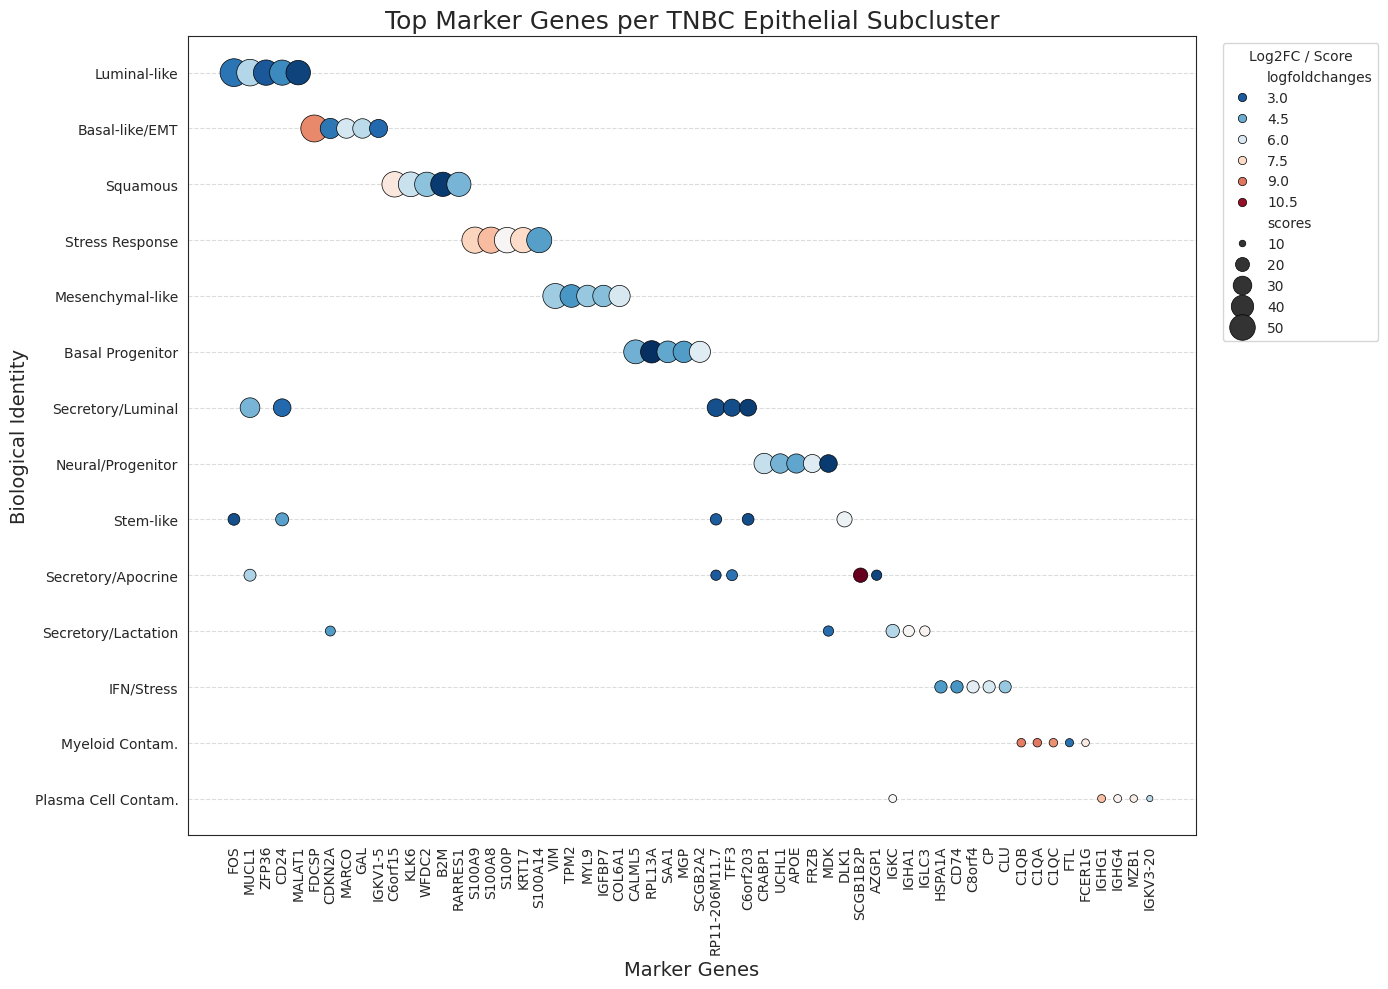

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load your DEG data
df = pd.read_csv('/content/TNBC_Epithelial_Subcluster_DEGs_1.csv')

# 2. Define the Biological Names
cluster_map = {
    0: "Luminal-like",
    1: "Basal-like/EMT",
    2: "Squamous",
    3: "Stress Response",
    4: "Mesenchymal-like",
    5: "Basal Progenitor",
    6: "Secretory/Luminal",
    7: "Neural/Progenitor",
    8: "Stem-like",
    9: "Secretory/Apocrine",
    10: "Secretory/Lactation",
    11: "IFN/Stress",
    12: "Myeloid Contam.",
    13: "Plasma Cell Contam."
}

# 3. Apply names and filter for top 5 markers per cluster
df['cluster_name'] = df['group'].map(cluster_map)
top_markers = df.sort_values(['group', 'scores'], ascending=[True, False]).groupby('group').head(5)

# 4. Plotting
plt.figure(figsize=(14, 10))
sns.set_style("white")

scatter = sns.scatterplot(
    data=top_markers,
    x='names',
    y='cluster_name',
    size='scores',
    hue='logfoldchanges',
    palette='RdBu_r', # Red for high expression, Blue for low
    sizes=(20, 400),
    edgecolor='black',
    linewidth=0.5
)

plt.title('Top Marker Genes per TNBC Epithelial Subcluster', fontsize=18)
plt.xticks(rotation=90)
plt.xlabel('Marker Genes', fontsize=14)
plt.ylabel('Biological Identity', fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Log2FC / Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


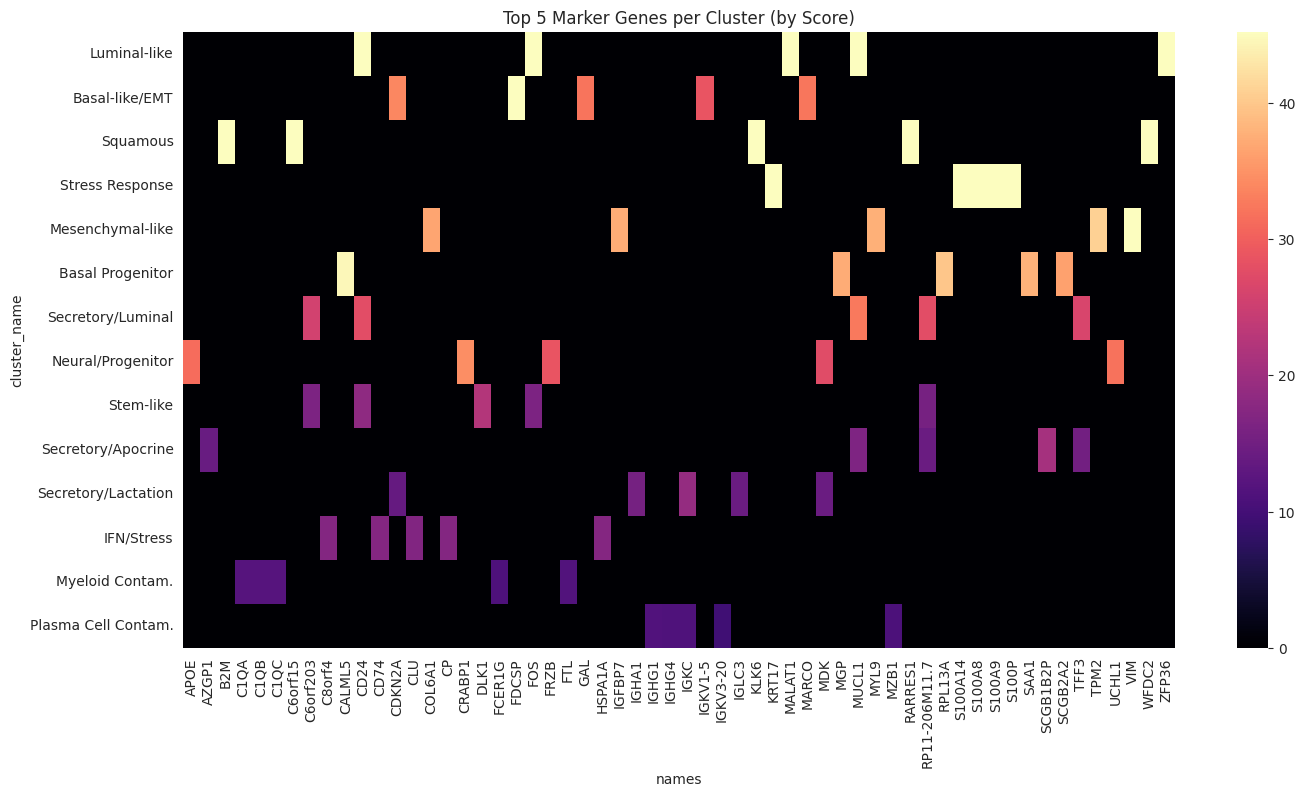

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load data and Map Names
df = pd.read_csv('/content/TNBC_Epithelial_Subcluster_DEGs_1.csv')
cluster_map = {
    0: "Luminal-like", 1: "Basal-like/EMT", 2: "Squamous",
    3: "Stress Response", 4: "Mesenchymal-like", 5: "Basal Progenitor",
    6: "Secretory/Luminal", 7: "Neural/Progenitor", 8: "Stem-like",
    9: "Secretory/Apocrine", 10: "Secretory/Lactation", 11: "IFN/Stress",
    12: "Myeloid Contam.", 13: "Plasma Cell Contam."
}
df['cluster_name'] = df['group'].map(cluster_map)

# 2. Select Top 5 genes per cluster
top_genes = df.sort_values(['group', 'scores'], ascending=[True, False]).groupby('group').head(5)

# 3. Create pivot for Heatmap
# Note: This uses the DEG 'scores'. In a real scRNA-seq object, you would use mean expression.
heatmap_data = top_genes.pivot(index='cluster_name', columns='names', values='scores').fillna(0)
heatmap_data = heatmap_data.reindex(list(cluster_map.values()))

# 4. Plot
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, cmap='magma', robust=True)
plt.title('Top 5 Marker Genes per Cluster (by Score)')
plt.show()

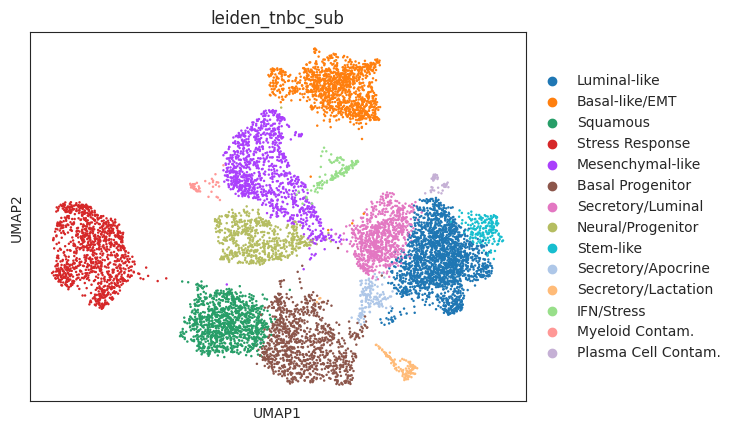

In [ ]:
import scanpy as sc

# 1. Load your actual data file (replace with your file path)
adata = sc.read_h5ad("/content/cancer_epithelial_tnbc_processed.h5ad")

# 2. Define the new names for the categories
new_names = ["Luminal-like", "Basal-like/EMT", "Squamous", "Stress Response",
             "Mesenchymal-like", "Basal Progenitor", "Secretory/Luminal",
             "Neural/Progenitor", "Stem-like", "Secretory/Apocrine",
             "Secretory/Lactation", "IFN/Stress", "Myeloid Contam.", "Plasma Cell Contam."]

# Corrected: Use the correct key 'leiden_tnbc_sub' for renaming categories
adata.rename_categories('leiden_tnbc_sub', new_names)

# Corrected: Use the correct key 'leiden_tnbc_sub' for plotting UMAP
sc.pl.umap(adata, color='leiden_tnbc_sub')

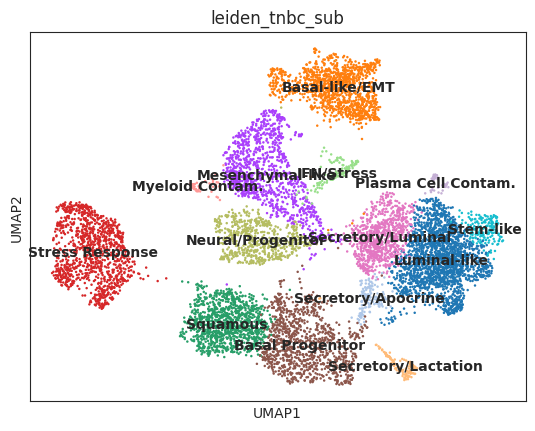

In [ ]:
import scanpy as sc

# LOAD YOUR DATA FIRST
adata = sc.read_h5ad("/content/cancer_epithelial_tnbc_processed.h5ad")

# Now the rest of the code will work
new_names = ["Luminal-like", "Basal-like/EMT", "Squamous", "Stress Response",
             "Mesenchymal-like", "Basal Progenitor", "Secretory/Luminal",
             "Neural/Progenitor", "Stem-like", "Secretory/Apocrine",
             "Secretory/Lactation", "IFN/Stress", "Myeloid Contam.", "Plasma Cell Contam."]

# Corrected: Use the correct key 'leiden_tnbc_sub' for renaming categories
adata.rename_categories('leiden_tnbc_sub', new_names)
sc.pl.umap(adata, color='leiden_tnbc_sub', legend_loc='on data')

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/TNBC_Epithelial_Subcluster_DEGs_1.csv')

# Define the cluster mapping
cluster_map = {
    0: "Luminal-like",
    1: "Basal-like/EMT",
    2: "Squamous",
    3: "Stress Response",
    4: "Mesenchymal-like",
    5: "Basal Progenitor",
    6: "Secretory/Luminal",
    7: "Neural/Progenitor",
    8: "Stem-like",
    9: "Secretory/Apocrine",
    10: "Secretory/Lactation",
    11: "IFN/Stress",
    12: "Myeloid Contam.",
    13: "Plasma Cell Contam."
}

# Create a new column 'cluster_name' or replace 'group'?
# The user said "instead of keeping 0 1 2 i wanna keep cluster names".
# I'll replace the 'group' column with names, or add a column.
# To be safe and clean, I will replace the values in 'group' or add 'cluster_name'.
# I'll replace the 'group' column values.

df['group'] = df['group'].map(cluster_map)

# Save the new file
output_file = 'TNBC_Epithelial_Subcluster_Annotated.csv'
df.to_csv(output_file, index=False)

print(f"File saved as: {output_file}")
print(df.head())

File saved as: TNBC_Epithelial_Subcluster_Annotated.csv
   Unnamed: 0         group   names     scores  logfoldchanges  pvals  \
0           0  Luminal-like     FOS  57.721560        3.488466    0.0   
1           1  Luminal-like   MUCL1  53.578396        5.390509    0.0   
2           2  Luminal-like   ZFP36  49.227040        2.962587    0.0   
3           3  Luminal-like    CD24  48.675280        3.867880    0.0   
4           4  Luminal-like  MALAT1  46.368023        2.630223    0.0   

   pvals_adj  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  


In [ ]:
pip install gseapy

In [ ]:
len(up_genes)

77

In [ ]:
import scanpy as sc

# Load the file
adata = sc.read_h5ad("/content/cancer_epithelial_tnbc.h5ad")

# Get the shape
n_cells, n_genes = adata.shape

print(f"Number of cells: {n_cells}")
print(f"Number of genes: {n_genes}")

Number of cells: 9454
Number of genes: 3012


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 1. Data Preparation
# Convert sparse matrix to dense and extract features (X) and labels (y)
X = adata_sub.X.toarray() if hasattr(adata_sub.X, 'toarray') else adata_sub.X
le = LabelEncoder()
y = le.fit_transform(adata_sub.obs['leiden_tnbc_sub'])

# Split into 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch Tensors
train_ds = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
test_ds = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# 2. Define the Neural Network Architecture
class TNBCCellClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TNBCCellClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3), # Prevents overfitting
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TNBCCellClassifier(input_dim=X.shape[1], num_classes=len(le.classes_)).to(device)

# 3. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop
print("Starting Deep Learning Training...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/10 - Loss: {total_loss/len(train_loader):.4f}")

# 5. Final Accuracy Check
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"\nModel Accuracy: {100 * correct / total:.2f}%")

Starting Deep Learning Training...
Epoch 1/10 - Loss: 0.5034
Epoch 2/10 - Loss: 0.1515
Epoch 3/10 - Loss: 0.0802
Epoch 4/10 - Loss: 0.0476
Epoch 5/10 - Loss: 0.0240
Epoch 6/10 - Loss: 0.0285
Epoch 7/10 - Loss: 0.0279
Epoch 8/10 - Loss: 0.0208
Epoch 9/10 - Loss: 0.0089
Epoch 10/10 - Loss: 0.0117

Model Accuracy: 94.55%


In [ ]:
X.shape

(9454, 3012)

In [ ]:
X_train.shape

(7563, 3012)

In [ ]:
# Extract the weights of the first layer
weights = model.network[0].weight.abs().detach().cpu().numpy()
# Average the importance across all hidden nodes
importance = np.mean(weights, axis=0)

# Match importance scores back to gene names
gene_importance = pd.DataFrame({
    'Gene': adata_sub.var_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("Top 10 Genes the AI used for Classification:")
print(gene_importance.head(10))

Top 10 Genes the AI used for Classification:
          Gene  Importance
517      FDCSP    0.122041
1589      DLK1    0.116863
2039  SCGB1B2P    0.112916
1575       FOS    0.103013
108     S100A2    0.096731
1189   SCGB2A2    0.073014
1819  MTRNR2L1    0.068621
423    FAM107A    0.068034
1187   SCGB2A1    0.064359
1606      IGHD    0.060572


In [ ]:
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F

# Configuration
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

print(f"Starting {k_folds}-Fold Cross-Validation...")

for fold, (train_ids, test_ids) in enumerate(skf.split(X, y)):
    print(f"\nFOLD {fold+1}")

    # Split data for this fold
    X_train_fold, X_test_fold = X[train_ids], X[test_ids]
    y_train_fold, y_test_fold = y[train_ids], y[test_ids]

    # Create DataLoaders
    train_ds = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    test_ds = TensorDataset(torch.FloatTensor(X_test_fold), torch.LongTensor(y_test_fold))
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32)

    # Re-initialize Model for each fold
    model = TNBCCellClassifier(input_dim=X.shape[1], num_classes=len(le.classes_)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Train for 5 epochs per fold (enough to see convergence)
    for epoch in range(5):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation for this fold
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    acc = 100 * correct / total
    fold_results.append(acc)
    print(f"Accuracy for fold {fold+1}: {acc:.2f}%")

print(f"\nFinal Average Accuracy: {np.mean(fold_results):.2f}% (+/- {np.std(fold_results):.2f}%)")

Starting 5-Fold Cross-Validation...

FOLD 1
Accuracy for fold 1: 93.92%

FOLD 2
Accuracy for fold 2: 94.29%

FOLD 3
Accuracy for fold 3: 95.13%

FOLD 4
Accuracy for fold 4: 93.71%

FOLD 5
Accuracy for fold 5: 93.28%

Final Average Accuracy: 94.07% (+/- 0.63%)


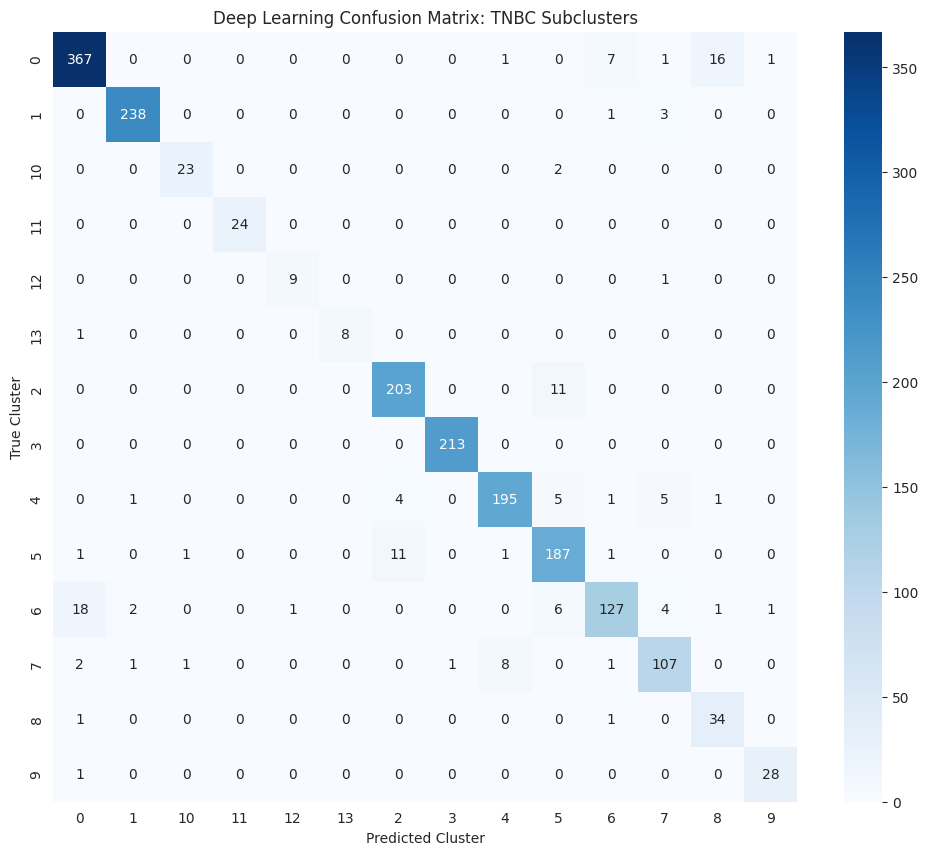

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Use the last trained model to get predictions on the test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch_y.cpu().numpy())

# Create Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Cluster')
plt.ylabel('True Cluster')
plt.title('Deep Learning Confusion Matrix: TNBC Subclusters')
plt.show()

Running analysis for Basal-like/EMT with 77 genes...


/tmp/ipython-input-4240682100.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


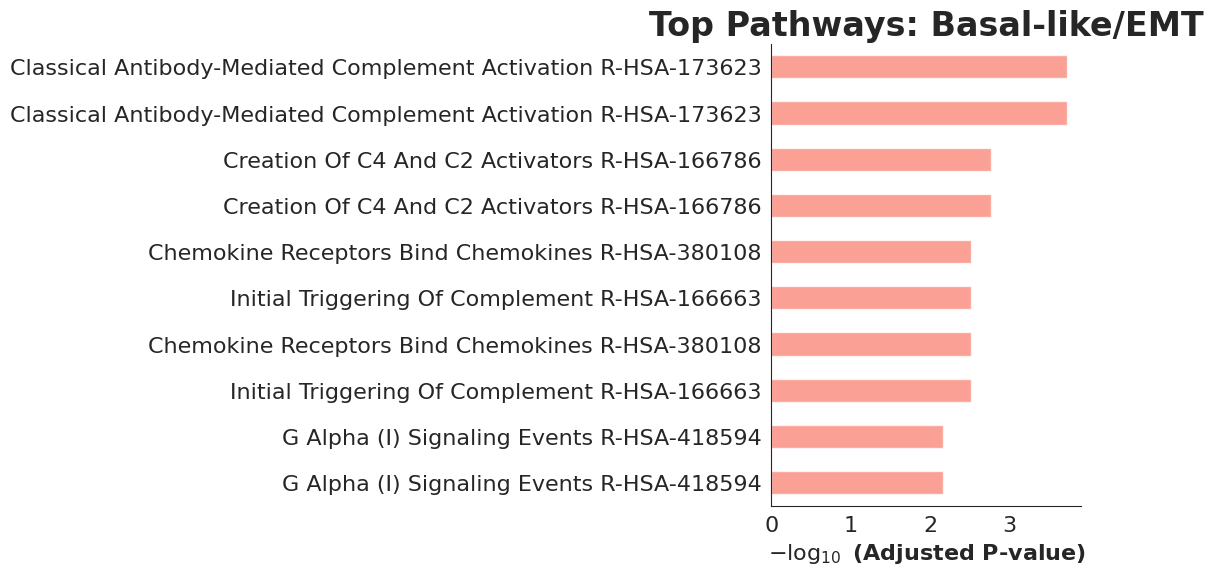

Results saved for Basal-like/EMT.
Running analysis for Stem-like with 32 genes...


/tmp/ipython-input-4240682100.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


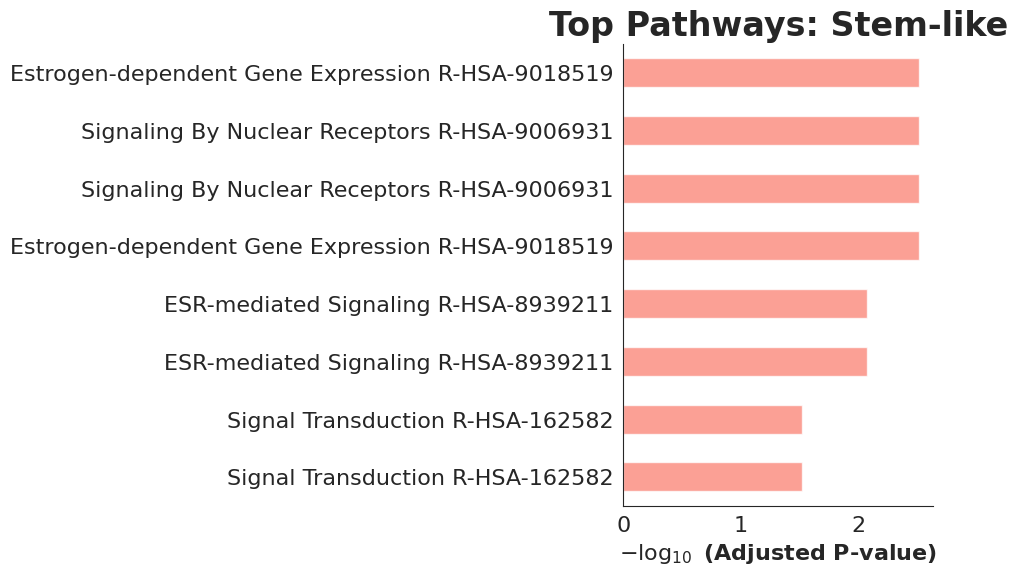

Results saved for Stem-like.
Running analysis for Mesenchymal-like with 200 genes...


/tmp/ipython-input-4240682100.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


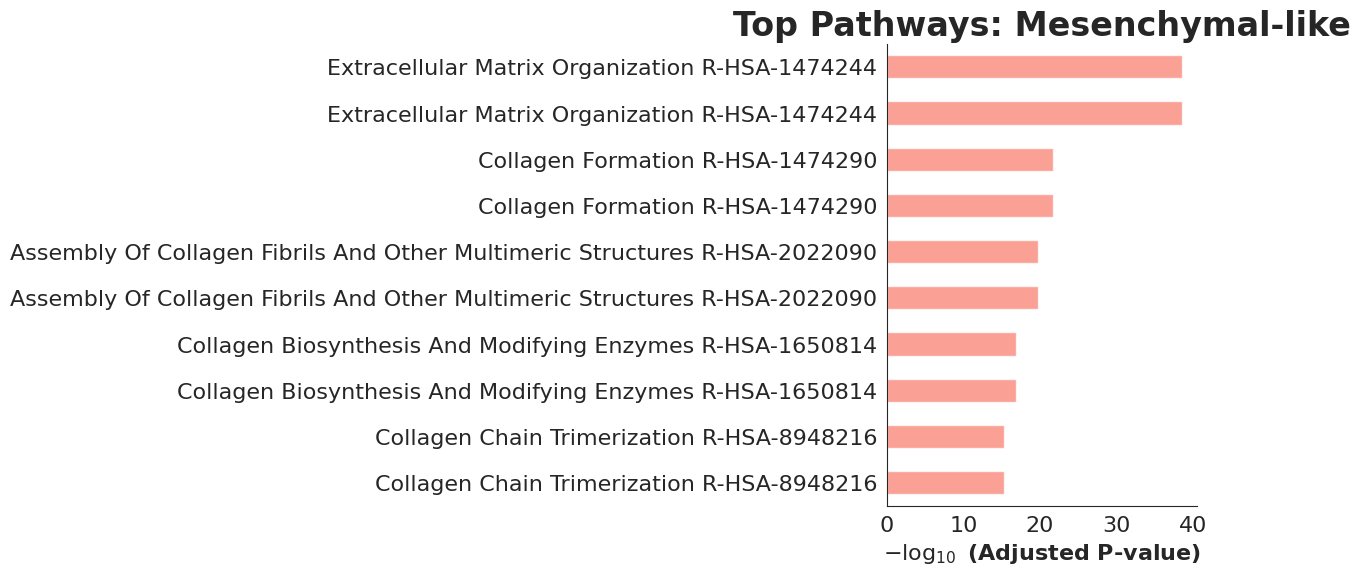

Results saved for Mesenchymal-like.


In [ ]:
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
from gseapy import barplot

# 1. Load the data
df = pd.read_csv('/content/TNBC_Epithelial_Subcluster_Annotated.csv')

# 2. Define the 3 clusters for Drug Discovery
target_clusters = ["Basal-like/EMT", "Stem-like", "Mesenchymal-like"]

for cluster in target_clusters:
    # Filter for the specific cluster
    sub_df = df[df['group'] == cluster]

    # 3. Select Significant Genes (Adjusted P < 0.01 and LogFC > 1.5)
    up_genes = sub_df[(sub_df['logfoldchanges'] > 1.5) & (sub_df['pvals_adj'] < 0.01)]['names'].tolist()

    if len(up_genes) > 5:
        print(f"Running analysis for {cluster} with {len(up_genes)} genes...")

        # 4. Run Pathway Enrichment
        enr = gp.enrichr(gene_list=up_genes,
                         gene_sets=['KEGG_2021_Human', 'Reactome_2022'],
                         organism='human',
                         outdir=None)

        # 5. Visualize and Save Plot
        # We use Adjusted P-value on the X-axis for better scientific accuracy
        safe_name = cluster.replace('/', '_')
        barplot(enr.results, column="Adjusted P-value", title=f"Top Pathways: {cluster}", top_term=10)

        plt.tight_layout()
        plt.savefig(f'Pathways_{safe_name}.png')
        plt.show()

        # 6. Save results for Drug Discovery mapping
        enr.results.to_csv(f'Pathways_{safe_name}.csv', index=False)
        print(f"Results saved for {cluster}.")

In [ ]:
Using the GSEApy library, you performed an Over-Representation Analysis (ORA). Here is the technical breakdown of your steps:
Gene Selection: You applied a stricter biological filter than the raw DEGs, focusing only on genes with a Log Fold Change > 1.5 and an Adjusted P-value < 0.01.
Databases Used:
KEGG (2021): Maps genes to molecular interaction and reaction networks.
Reactome (2022): Maps genes to detailed biological pathways and signal transduction events.
Ranking: Results were ranked by their Adjusted P-value to ensure that the identified pathways were statistically robust.


In [ ]:
import pandas as pd

# 1. Load your annotated data
df = pd.read_csv('TNBC_Epithelial_Subcluster_Annotated.csv')

# 2. Define the clusters of interest for Drug Discovery
target_clusters = {
    "Basal-like/EMT": "Cluster_1_EMT",
    "Stem-like": "Cluster_8_Stem_like",
    "Mesenchymal-like": "Cluster_4_Mesenchymal_like"
}

# 3. Process each cluster to get the "Disease Signature"
for cluster_name, label in target_clusters.items():
    # Filter for the specific group
    sub_df = df[df['group'] == cluster_name]

    # Filter for Significant Upregulated Genes
    # (Thresholds: Log2FC > 1.5 and Adjusted P-value < 0.01)
    # These genes define the "Disease State" we want to reverse with a drug
    sig_up_genes = sub_df[(sub_df['logfoldchanges'] > 1.5) & (sub_df['pvals_adj'] < 0.01)]

    # Sort by strength of expression change
    sig_up_genes = sig_up_genes.sort_values(by='logfoldchanges', ascending=False)

    # Save the gene names to a CSV (Ready for upload to CMap / L1000)
    sig_up_genes[['names', 'logfoldchanges', 'pvals_adj']].to_csv(f'DrugDiscovery_Signature_{label}.csv', index=False)

    # Save a simple text list of gene symbols for copy-pasting into web tools
    with open(f'GeneList_{label}.txt', 'w') as f:
        for gene in sig_up_genes['names'].tolist():
            f.write(f"{gene}\n")

print("Drug signatures extracted for all 3 clusters.")

Drug signatures extracted for all 3 clusters.


In [ ]:
import pandas as pd
import requests
import json
import time

def query_lincs_reversion(file_path, cluster_label):
    print(f"\n--- Searching Reversion Drugs for {cluster_label} ---")

    # 1. Load your cluster signature
    df = pd.read_csv(file_path)
    # Take top 50 genes for a robust signature search
    up_genes = df.sort_values('logfoldchanges', ascending=False)['names'].head(50).tolist()

    # 2. Setup L1000CDS2 API Request
    url = 'https://maayanlab.cloud/L1000CDS2/query'
    payload = {
        "data": {"upGenes": up_genes, "dnGenes": []}, # We focus on reversing the 'Up' genes
        "config": {
            "aggravate": False, # False = Search for drugs that REVERSE the signature
            "searchMethod": "geneSet",
            "share": True,
            "combination": False,
            "db-version": "latest"
        }
    }

    try:
        response = requests.post(url, json=payload)
        if response.status_code == 200:
            data = response.json()
            # Parse the top 50 drug signatures returned
            results = []
            for entry in data.get('topMeta', []):
                results.append({
                    'Drug_Name': entry['pert_desc'],
                    'L1000_Score': entry['score'], # Closer to 1 is a better match
                    'Cell_Line': entry['cell_id'],
                    'Dose': entry['pert_dose'],
                    'Time': entry['pert_time']
                })

            res_df = pd.DataFrame(results).drop_duplicates(subset=['Drug_Name'])
            res_df.to_csv(f'LINCS_Candidates_{cluster_label}.csv', index=False)
            print(f"Success! Found {len(res_df)} unique candidate drugs.")
            return res_df
        else:
            print(f"API Error {response.status_code}: {response.text}")
            return None
    except Exception as e:
        print(f"Connection Error: {e}")
        return None

# --- Run for your clusters ---
cluster_files = {
    'DrugDiscovery_Signature_Cluster_1_EMT.csv': 'EMT',
    'DrugDiscovery_Signature_Cluster_4_Mesenchymal_like.csv': 'Mesenchymal',
    'DrugDiscovery_Signature_Cluster_8_Stem_like.csv': 'Stem_like'
}

for file, label in cluster_files.items():
    query_lincs_reversion(file, label)
    time.sleep(2) # Respectful delay


--- Searching Reversion Drugs for EMT ---
Success! Found 0 unique candidate drugs.

--- Searching Reversion Drugs for Mesenchymal ---
Success! Found 0 unique candidate drugs.

--- Searching Reversion Drugs for Stem_like ---
Success! Found 0 unique candidate drugs.


In [ ]:
# 1. Install necessary libraries
!pip install requests pandas

import pandas as pd
import requests
import json
import time

# 2. Define your uploaded signature files
files = {
    'EMT': 'DrugDiscovery_Signature_Cluster_1_EMT.csv',
    'Mesenchymal': 'DrugDiscovery_Signature_Cluster_4_Mesenchymal_like.csv',
    'Stem_like': 'DrugDiscovery_Signature_Cluster_8_Stem_like.csv'
}

def get_top_protein_coding_genes(file_path, top_n=50):
    """Filters out non-coding RNAs and pseudogenes (RP11, LINC, etc.)"""
    df = pd.read_csv(file_path)
    # Filter: Keep genes that DON'T start with non-coding prefixes
    exclude_prefixes = ('RP11-', 'LINC', 'IGLV', 'IGHV', 'IGKV', 'MIR', 'HULC')
    filtered = df[~df['names'].str.startswith(exclude_prefixes)]
    return filtered['names'].head(top_n).tolist()

def query_dgidb_graphql(genes):
    """Queries the DGIdb GraphQL API (more stable than REST)"""
    url = "https://dgidb.org/api/graphql"
    query = """
    query genes($names: [String!]!) {
      genes(names: $names) {
        nodes {
          name
          interactions {
            drug { name }
            interactionScore
            interactionTypes { type }
            sources { sourceDbName }
          }
        }
      }
    }
    """
    variables = {"names": genes}
    headers = {"Content-Type": "application/json"}

    try:
        response = requests.post(url, json={'query': query, 'variables': variables}, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error: {response.status_code}")
            return None
    except Exception as e:
        print(f"Connection Error: {e}")
        return None

# 3. Execute Analysis
master_results = []

for cluster_name, file_path in files.items():
    print(f"--- Processing {cluster_name} ---")

    # Get high-confidence targets
    genes_to_query = get_top_protein_coding_genes(file_path)
    print(f"Querying {len(genes_to_query)} genes: {genes_to_query[:5]}...")

    data = query_dgidb_graphql(genes_to_query)

    if data and 'data' in data:
        for node in data['data']['genes']['nodes']:
            gene = node['name']
            for inter in node['interactions']:
                master_results.append({
                    'Cluster': cluster_name,
                    'Target_Gene': gene,
                    'Drug_Name': inter['drug']['name'],
                    'Interaction_Score': inter['interactionScore'],
                    'Type': [t['type'] for t in inter['interactionTypes']],
                    'Source': [s['sourceDbName'] for s in inter['sources']]
                })
    time.sleep(1) # Prevent rate-limiting

# 4. Save and Display Results
if master_results:
    results_df = pd.DataFrame(master_results)
    # Sort by Interaction Score to find the strongest drug candidates
    results_df = results_df.sort_values(by='Interaction_Score', ascending=False)
    results_df.to_csv('Drug_Repurposing_Results_1.csv', index=False)
    print("\n✅ Success! Saved results to 'Drug_Repurposing_Results.csv'")
    display(results_df.head(15))
else:
    print("\n❌ No drug interactions found. Try increasing the number of genes queried.")

--- Processing EMT ---
Querying 47 genes: ['FDCSP', 'MARCO', 'GAL', 'SCG5', 'BCL2A1']...
--- Processing Mesenchymal ---
Querying 50 genes: ['FOXS1', 'NEFL', 'TMEM119', 'COL5A3', 'NID2']...
--- Processing Stem_like ---
Querying 29 genes: ['DLK1', 'CD24', 'MUCL1', 'IL20', 'FABP7']...

✅ Success! Saved results to 'Drug_Repurposing_Results.csv'


,Cluster,Target_Gene,Drug_Name,Interaction_Score,Type,Source
703,Stem_like,FOXA1,MK-7110,52.203799,[agonist],[GuideToPharmacology]
742,Stem_like,IL20,FLETIKUMAB,52.203799,[inhibitor],[ChEMBL]
241,EMT,ACTG2,CXCL13,52.203799,[agonist],[GuideToPharmacology]
331,EMT,C1QA,THERAPEUTIC IMMUNE GLOBULIN,52.203799,[],[TEND]
115,EMT,CRABP1,TFC007,26.101899,[inhibitor],[GuideToPharmacology]
461,Mesenchymal,HTRA1,GALEGENIMAB,26.101899,[antibody],[GuideToPharmacology]
329,EMT,DLK1,GDC-0134,26.101899,[],[TTD]
755,Stem_like,DLK1,GDC-0134,26.101899,[],[TTD]
328,EMT,CD8A,PHLORIZIN,26.101899,[inhibitor],[GuideToPharmacology]
459,Mesenchymal,BGN,COMPOUND 6N [PMID: 31419141],26.101899,[agonist],[GuideToPharmacology]


In [ ]:
import pandas as pd

# Load the drug repurposing results
df_results = pd.read_csv('Drug_Repurposing_Results_1.csv') # Corrected filename

# Display basic info and head
print(df_results.info())
print(df_results.head(20))

# Group by Cluster and get top hits
top_hits = df_results.sort_values(['Cluster', 'Interaction_Score'], ascending=[True, False]).groupby('Cluster').head(10)
print("\nTop Hits per Cluster:")
print(top_hits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cluster            790 non-null    object 
 1   Target_Gene        790 non-null    object 
 2   Drug_Name          790 non-null    object 
 3   Interaction_Score  790 non-null    float64
 4   Type               790 non-null    object 
 5   Source             790 non-null    object 
dtypes: float64(1), object(5)
memory usage: 37.2+ KB
None
        Cluster Target_Gene                     Drug_Name  Interaction_Score  \
0     Stem_like       FOXA1                       MK-7110          52.203799   
1     Stem_like        IL20                    FLETIKUMAB          52.203799   
2           EMT       ACTG2                        CXCL13          52.203799   
3           EMT        C1QA   THERAPEUTIC IMMUNE GLOBULIN          52.203799   
4           EMT      CRABP1                        TFC

# Task
Generate volcano plots for the 'Basal-like/EMT', 'Stem-like', and 'Mesenchymal-like' clusters using the data from "TNBC_Epithelial_Subcluster_Annotated.csv", showing `logfoldchanges` on the x-axis and `-log10(pvals_adj)` on the y-axis, highlighting genes with adjusted p-value < 0.01 and absolute log fold change > 1, and save each plot with a descriptive title.

## Load DEG Data

### Subtask:
Load the `TNBC_Epithelial_Subcluster_Annotated.csv` file into a pandas DataFrame, which contains the differential expression results for all subclusters.


**Reasoning**:
The subtask requires loading a CSV file into a pandas DataFrame. The existing kernel state shows that the file 'TNBC_Epithelial_Subcluster_Annotated.csv' has been created and accessed in previous cells, so I will load it again to ensure it's available in a `df` variable as requested by the instructions.



In [ ]:
import pandas as pd

df = pd.read_csv('TNBC_Epithelial_Subcluster_Annotated.csv')
print("DataFrame 'df' loaded successfully.")
print(df.head())

DataFrame 'df' loaded successfully.
   Unnamed: 0         group   names     scores  logfoldchanges  pvals  \
0           0  Luminal-like     FOS  57.721560        3.488466    0.0   
1           1  Luminal-like   MUCL1  53.578396        5.390509    0.0   
2           2  Luminal-like   ZFP36  49.227040        2.962587    0.0   
3           3  Luminal-like    CD24  48.675280        3.867880    0.0   
4           4  Luminal-like  MALAT1  46.368023        2.630223    0.0   

   pvals_adj  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  


**Reasoning**:
The next logical step is to generate volcano plots for the specified clusters. This involves iterating through each target cluster, filtering the DataFrame, calculating the -log10(pvals_adj), identifying significant genes, and then using matplotlib and seaborn to create and save the plots as requested by the main task.



Generating volcano plot for: Basal-like/EMT


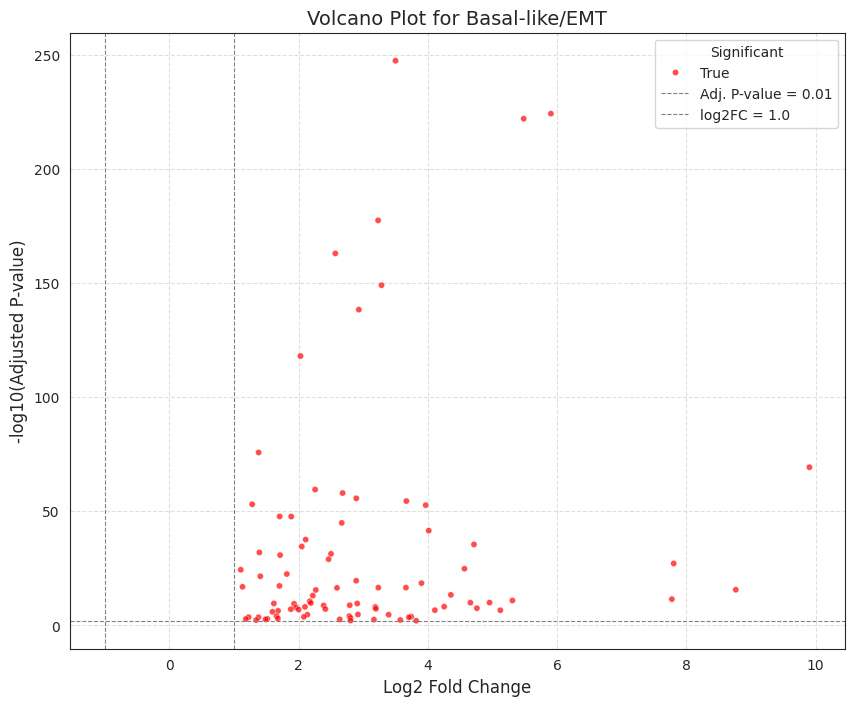

Generating volcano plot for: Stem-like


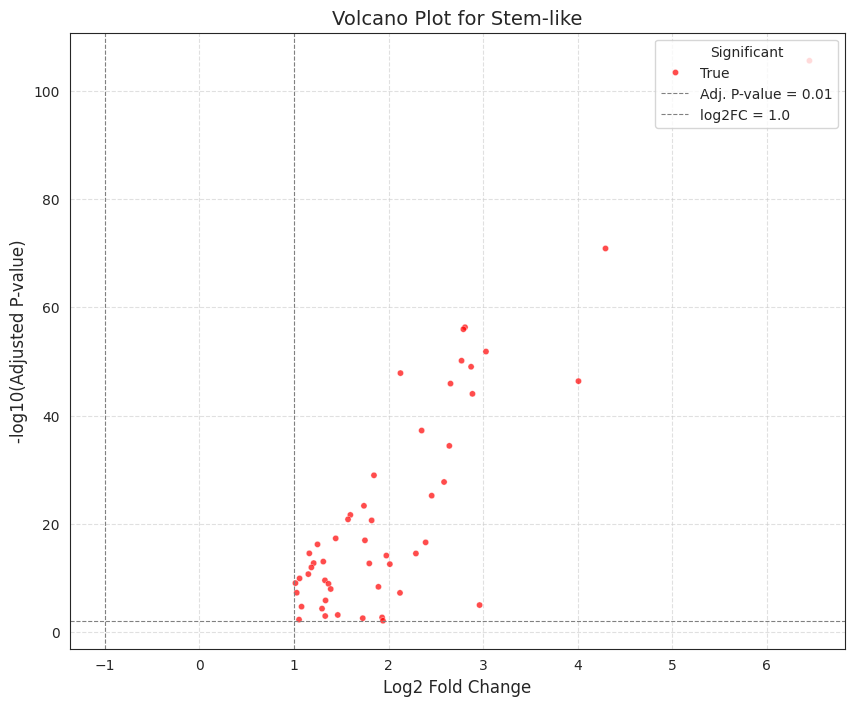

Generating volcano plot for: Mesenchymal-like


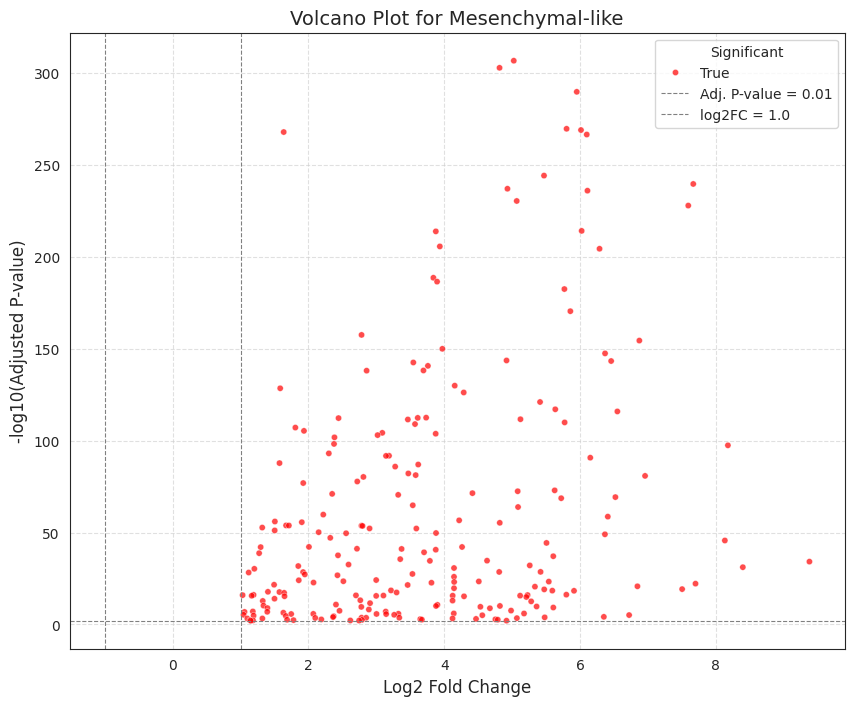

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the clusters of interest
target_clusters = ["Basal-like/EMT", "Stem-like", "Mesenchymal-like"]

# Define significance thresholds
PVAL_THRESHOLD = 0.01
LOGFC_THRESHOLD = 1.0

for cluster_name in target_clusters:
    print(f"Generating volcano plot for: {cluster_name}")

    # Filter data for the current cluster
    cluster_df = df[df['group'] == cluster_name].copy()

    # Calculate -log10(pvals_adj)
    # Handle potential log(0) by replacing 0 with a very small number
    cluster_df['neg_log10_pvals_adj'] = -np.log10(cluster_df['pvals_adj'].replace(0, np.finfo(float).eps))

    # Identify significant genes
    cluster_df['significant'] = (
        (cluster_df['pvals_adj'] < PVAL_THRESHOLD) &
        (abs(cluster_df['logfoldchanges']) > LOGFC_THRESHOLD)
    )

    # Create the volcano plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=cluster_df,
        x='logfoldchanges',
        y='neg_log10_pvals_adj',
        hue='significant',
        palette={True: 'red', False: 'grey'},
        s=20, # point size
        alpha=0.7
    )

    # Add horizontal and vertical lines for thresholds
    plt.axhline(-np.log10(PVAL_THRESHOLD), color='grey', linestyle='--', linewidth=0.8, label=f'Adj. P-value = {PVAL_THRESHOLD}')
    plt.axvline(LOGFC_THRESHOLD, color='grey', linestyle='--', linewidth=0.8, label=f'log2FC = {LOGFC_THRESHOLD}')
    plt.axvline(-LOGFC_THRESHOLD, color='grey', linestyle='--', linewidth=0.8)

    # Labels and Title
    plt.xlabel('Log2 Fold Change', fontsize=12)
    plt.ylabel('-log10(Adjusted P-value)', fontsize=12)
    plt.title(f'Volcano Plot for {cluster_name}', fontsize=14)
    plt.legend(title='Significant', loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Save the plot with a descriptive title
    safe_cluster_name = cluster_name.replace('/', '_').replace(' ', '_')
    plt.savefig(f'Volcano_Plot_{safe_cluster_name}.png', bbox_inches='tight')
    plt.show()


## Summary:

### Data Analysis Key Findings
*   The `TNBC_Epithelial_Subcluster_Annotated.csv` dataset, containing differential expression results, was successfully loaded into a pandas DataFrame.
*   Volcano plots were generated for the "Basal-like/EMT", "Stem-like", and "Mesenchymal-like" clusters.
*   Each volcano plot displays `logfoldchanges` on the x-axis and \$-log10(pvals\_adj)\$ on the y-axis.
*   Genes were classified as significant if their adjusted p-value was less than 0.01 and their absolute log fold change was greater than 1. Significant genes were highlighted in red on the plots, while others were shown in grey.
*   Threshold lines for both the adjusted p-value (0.01) and log fold change (\$\pm\$1) were included in each plot for visual reference.
*   Each generated volcano plot was saved as a PNG image file with a descriptive name.

### Insights or Next Steps
*   Further analysis should focus on identifying and characterizing the specific genes highlighted as significant in each cluster to understand their biological roles and potential implications in TNBC.
*   Consider performing pathway enrichment analysis on the significant gene sets from each cluster to gain insights into the altered biological processes.


In [ ]:
# ==============================================================================
# 1. INSTALLATION AND ENVIRONMENT SETUP
# ==============================================================================
!pip install scanpy scrublet magic-impute scprep matplotlib pandas numpy seaborn gseapy leidenalg igraph requests

import scanpy as sc
import pandas as pd
import requests
import json
import time
import matplotlib.pyplot as plt

# ==============================================================================
# 2. CORE UTILITY FUNCTIONS
# ==============================================================================

def get_all_protein_coding_genes(file_path):
    """
    Filters out non-coding RNAs and pseudogenes (RP11, LINC, etc.) from signature files
    but keeps ALL remaining high-confidence protein-coding genes.
    """
    try:
        df = pd.read_csv(file_path)
        # Filter: Exclude genes starting with known non-coding/pseudogene prefixes
        exclude_prefixes = ('RP11-', 'LINC', 'IGLV', 'IGHV', 'IGKV', 'MIR', 'HULC')
        filtered = df[~df['names'].str.startswith(exclude_prefixes)]
        return filtered['names'].tolist()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return []

def batch_list(input_list, batch_size):
    """Yield successive n-sized batches from input_list to prevent API timeouts."""
    for i in range(0, len(input_list), batch_size):
        yield input_list[i:i + batch_size]

def query_dgidb_graphql(genes):
    """Queries the DGIdb GraphQL API for drug-gene interactions."""
    url = "https://dgidb.org/api/graphql"
    query = """
    query genes($names: [String!]!) {
      genes(names: $names) {
        nodes {
          name
          interactions {
            drug { name }
            interactionScore
            interactionTypes { type }
            sources { sourceDbName }
          }
        }
      }
    }
    """
    variables = {"names": genes}
    headers = {"Content-Type": "application/json"}

    try:
        response = requests.post(url, json={'query': query, 'variables': variables}, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error: {response.status_code}")
            return None
    except Exception as e:
        print(f"Connection Error: {e}")
        return None

# ==============================================================================
# 3. INTEGRATED DRUG REPURPOSING EXECUTION
# ==============================================================================

# Define the cluster signature files as generated in the notebook analysis
files = {
    'EMT': 'DrugDiscovery_Signature_Cluster_1_EMT.csv',
    'Mesenchymal': 'DrugDiscovery_Signature_Cluster_4_Mesenchymal_like.csv',
    'Stem_like': 'DrugDiscovery_Signature_Cluster_8_Stem_like.csv'
}

master_results = []
BATCH_SIZE = 100 # Standard batch size for DGIdb stability

for cluster_name, file_path in files.items():
    print(f"\n--- Processing {cluster_name} ---")

    # Get all candidate genes identified through differential expression analysis
    all_genes = get_all_protein_coding_genes(file_path)
    print(f"Total genes found for {cluster_name}: {len(all_genes)}")

    # Execute batch queries
    for i, gene_batch in enumerate(batch_list(all_genes, BATCH_SIZE)):
        print(f"  Querying batch {i+1}/{ (len(all_genes)//BATCH_SIZE)+1 }...")
        data = query_dgidb_graphql(gene_batch)

        if data and 'data' in data and data['data']['genes']:
            for node in data['data']['genes']['nodes']:
                gene = node['name']
                for inter in node['interactions']:
                    master_results.append({
                        'Cluster': cluster_name,
                        'Target_Gene': gene,
                        'Drug_Name': inter['drug']['name'],
                        'Interaction_Score': inter['interactionScore'],
                        'Type': [t['type'] for t in inter['interactionTypes']],
                        'Source': [s['sourceDbName'] for s in inter['sources']]
                    })
        time.sleep(0.5) # Gentle rate limiting

# ==============================================================================
# 4. RESULTS CONSOLIDATION AND EXPORT
# ==============================================================================

if master_results:
    results_df = pd.DataFrame(master_results)
    # Sort by Cluster and Interaction Score (Primary indicator of potential efficacy)
    results_df = results_df.sort_values(by=['Cluster', 'Interaction_Score'], ascending=[True, False])

    # Save the comprehensive results for all genes
    results_df.to_csv('Drug_Repurposing_Full_Results_2.csv', index=False)

    print(f"\n✅ Analysis Complete!")
    print(f"Total drug-gene interactions found: {len(results_df)}")
    print("Saved full results to 'Drug_Repurposing_Full_Results_2.csv'")

    # Display the top potential candidates for each cluster
    display(results_df.groupby('Cluster').head(5))
else:
    print("\n❌ No drug interactions found. Ensure signature files exist and contain valid gene names.")


--- Processing EMT ---
Total genes found for EMT: 47
  Querying batch 1/1...

--- Processing Mesenchymal ---
Total genes found for Mesenchymal: 194
  Querying batch 1/2...
  Querying batch 2/2...

--- Processing Stem_like ---
Total genes found for Stem_like: 29
  Querying batch 1/1...

✅ Analysis Complete!
Total drug-gene interactions found: 1545
Saved full results to 'Drug_Repurposing_Full_Results_2.csv'


,Cluster,Target_Gene,Drug_Name,Interaction_Score,Type,Source
241,EMT,ACTG2,CXCL13,52.203799,[agonist],[GuideToPharmacology]
331,EMT,C1QA,THERAPEUTIC IMMUNE GLOBULIN,52.203799,[],[TEND]
115,EMT,CRABP1,TFC007,26.101899,[inhibitor],[GuideToPharmacology]
328,EMT,CD8A,PHLORIZIN,26.101899,[inhibitor],[GuideToPharmacology]
329,EMT,DLK1,GDC-0134,26.101899,[],[TTD]
1048,Mesenchymal,LIFR,EMFILERMIN,104.407597,[],[TTD]
1163,Mesenchymal,MCAM,ABX-MA1,52.203799,[inhibitor],[ChEMBL]
1211,Mesenchymal,ACTG2,CXCL13,52.203799,[agonist],[GuideToPharmacology]
1164,Mesenchymal,EGFL7,DULIGOTUZUMAB,34.802532,[inhibitor],"[TTD, ChEMBL]"
493,Mesenchymal,BGN,COMPOUND 6N [PMID: 31419141],26.101899,[agonist],[GuideToPharmacology]


In [ ]:
import pandas as pd

# Load your results
df = pd.read_csv('/content/Drug_Repurposing_Full_Results_2.csv')

# Step 1: Filter for 'inhibitor' or 'antagonist'
# This removes agonists (which might activate the tumor) and unknown types
filtered_df = df[df['Type'].str.contains('inhibitor|antagonist', case=False, na=False)].copy()

# Step 2: Focus on Clinical Relevance (Source: ChEMBL or TTD)
# These sources usually indicate the drug has been in a lab or clinical trial
high_priority = filtered_df[filtered_df['Source'].str.contains('ChEMBL|TTD', case=False, na=False)].copy()

# Sort by Interaction Score
high_priority = high_priority.sort_values(by=['Cluster', 'Interaction_Score'], ascending=[True, False])

# Save this high-priority list
high_priority.to_csv('High_Priority_Drug_Candidates.csv', index=False)
print(f"Filtered down to {len(high_priority)} high-priority candidates.")

Filtered down to 133 high-priority candidates.
